<a href="https://colab.research.google.com/github/YunSu10/Final-Team8/blob/main/%ED%8C%8C%EC%9D%B4%EB%84%90%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84%EC%A4%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator, MaxNLocator
from typing import Dict
import statsmodels.api as sm
from statsmodels.formula.api import logit
from scipy.stats import chi2_contingency
from scipy import stats
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [6]:
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib as mpl
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

In [7]:
df = pd.read_csv("제조AI데이터셋_(주)코넥.csv", encoding="cp949")

In [8]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [9]:
df['불량여부_mid'] = df['불량여부'].apply(lambda x: x.mid if isinstance(x, pd._libs.interval.Interval) else x)

# 숫자형 컬럼만 선택해서 상관계수 계산
numeric_cols = df.select_dtypes(include=['float64','int64']).columns
corr = df[numeric_cols].corr()
print(corr['불량여부_mid'].sort_values(ascending=False))

불량여부_mid      1.000000
불량여부          1.000000
냉각수압력         0.364504
싸이클타임(sec)    0.349524
대기습도          0.333638
스프레이(sec)     0.327670
에어압력          0.309862
고속속도(m/s)     0.261754
승압시간(ms)      0.152235
탕구두께(mm)      0.073655
냉각수온도         0.072770
대기온도          0.039236
고속절환위치(mm)   -0.021460
보온로(℃)       -0.041419
고속구간(mm)     -0.055229
저속속도(m/s)    -0.088726
진공도(mmHg)    -0.091681
형체력(%)       -0.258281
주조압력(MPa)    -0.320587
Name: 불량여부_mid, dtype: float64


**대기온도와 대기 습도에 따른 대기압**

In [10]:
def calculate_pressure(temp_C, humidity_percent):
    # 1. 포화 수증기압 (Tetens 공식)
    e_s = 6.112 * np.exp(17.67 * temp_C / (temp_C + 243.5))  # hPa

    # 2. 실제 수증기압
    e = humidity_percent / 100 * e_s

    # 3. 총 대기압 계산 (간단화: 표준 대기압 - 수증기압)
    P = 1013.25 - e

    return P
df['대기압(hPa)'] = df.apply(lambda row: calculate_pressure(row['대기온도'], row['대기습도']), axis=1)
df['대기압(MPa)'] = df['대기압(hPa)'] * 1e-4


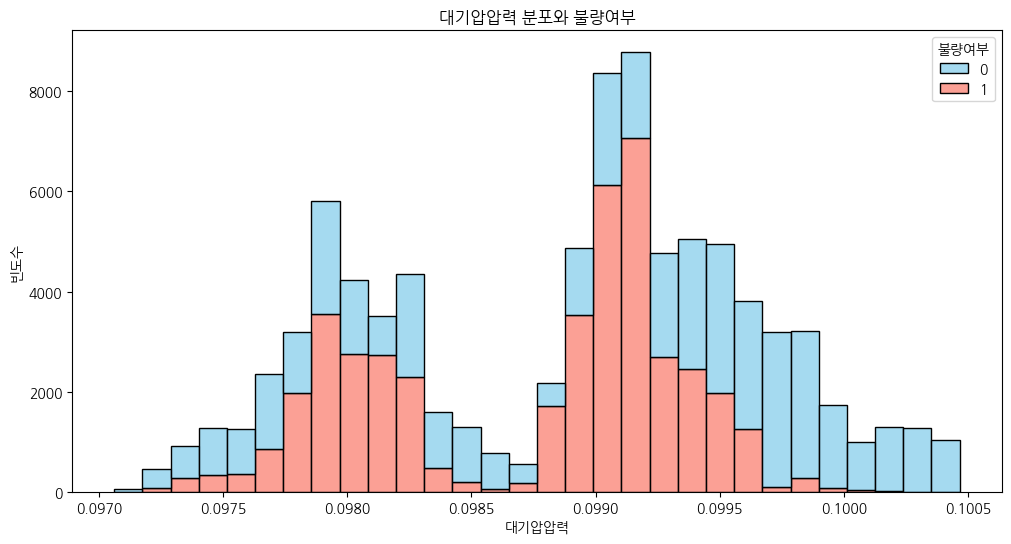

In [11]:
plt.figure(figsize=(12,6))

# 히스토그램: 불량 여부에 따라 색 다르게
sns.histplot(data=df, x='대기압(MPa)', hue='불량여부', bins=30, kde=False, multiple='stack', palette=['skyblue','salmon'])

plt.title('대기압압력 분포와 불량여부')
plt.xlabel('대기압압력')
plt.ylabel('빈도수')
plt.show()

In [12]:
# 1. 압력 구간 나누기 (10개 구간)
df['압력구간'] = pd.cut(df['대기압(MPa)'], bins=20)

# 2. 구간별 통계 계산
table = df.groupby('압력구간')['불량여부'].agg(
    불량수='sum',         # 불량 1의 개수
    전체수='count',        # 구간 내 전체 데이터 수
    불량률='mean'          # 평균 = 불량률
).reset_index()

print(table)

                  압력구간   불량수    전체수       불량률
0   (0.09706, 0.09723]    45    317  0.141956
1    (0.09723, 0.0974]   335   1163  0.288048
2    (0.0974, 0.09757]   598   1900  0.314737
3   (0.09757, 0.09774]  1004   3020  0.332450
4   (0.09774, 0.09791]  2993   5318  0.562806
5   (0.09791, 0.09808]  5295   7919  0.668645
6   (0.09808, 0.09825]  4132   5749  0.718734
7   (0.09825, 0.09842]  1386   3719  0.372681
8   (0.09842, 0.09859]   221   1811  0.122032
9   (0.09859, 0.09876]   235    849  0.276796
10  (0.09876, 0.09893]  3126   4179  0.748026
11   (0.09893, 0.0991]  8269  11198  0.738435
12   (0.0991, 0.09927]  8798  11501  0.764977
13  (0.09927, 0.09944]  3416   7085  0.482145
14  (0.09944, 0.09961]  3165   7218  0.438487
15  (0.09961, 0.09979]   183   4751  0.038518
16  (0.09979, 0.09996]   325   4281  0.075917
17   (0.09996, 0.1001]    76   1686  0.045077
18    (0.1001, 0.1003]    27   1933  0.013968
19    (0.1003, 0.1005]    15   1691  0.008870


/tmp/ipython-input-3221726179.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby('압력구간')['불량여부'].agg(


**대기압과 주조압력에 따른 불량여부**

/tmp/ipython-input-3453558510.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df.groupby(['주조압력_bin','대기압_bin'])['불량여부'].mean().unstack()


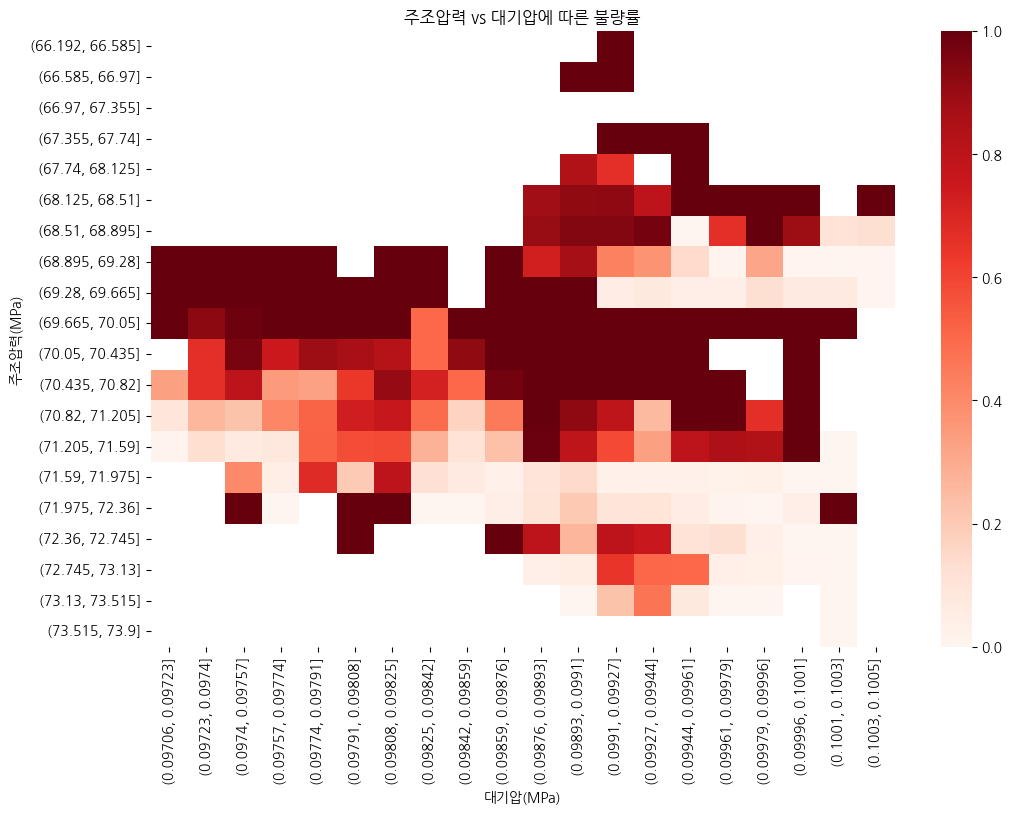

In [13]:
# 주조압력, 대기압 구간 나누기
df['주조압력_bin'] = pd.cut(df['주조압력(MPa)'], bins=20)
df['대기압_bin'] = pd.cut(df['대기압(MPa)'], bins=20)

# 구간별 불량률 계산
heatmap_data = df.groupby(['주조압력_bin','대기압_bin'])['불량여부'].mean().unstack()

# 시각화
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, cmap='Reds', annot=False)
plt.title('주조압력 vs 대기압에 따른 불량률')
plt.xlabel('대기압(MPa)')
plt.ylabel('주조압력(MPa)')
plt.show()


**주조압력**

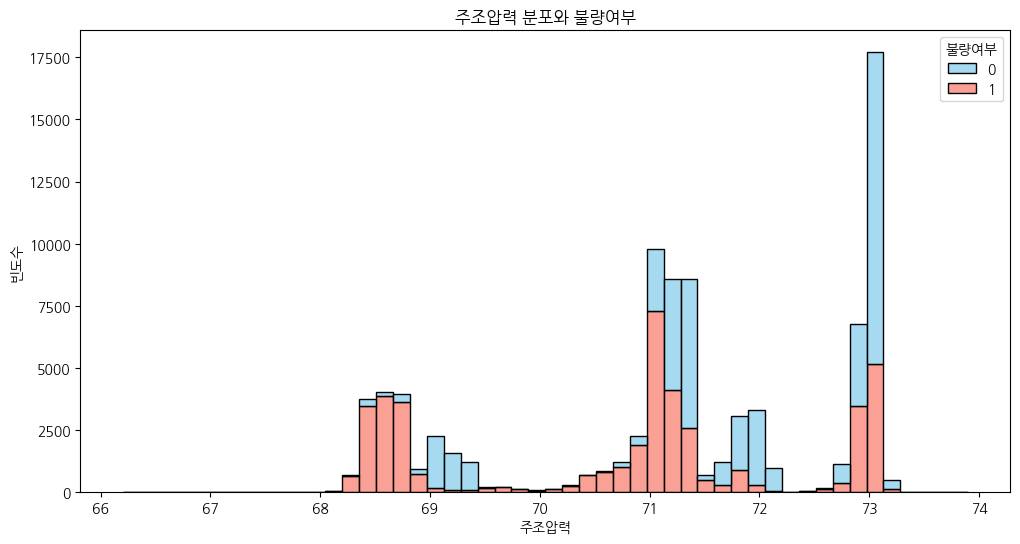

In [14]:
plt.figure(figsize=(12,6))

# 히스토그램: 불량 여부에 따라 색 다르게
sns.histplot(data=df, x='주조압력(MPa)', hue='불량여부', bins=50, kde=False, multiple='stack', palette=['skyblue','salmon'])

plt.title('주조압력 분포와 불량여부')
plt.xlabel('주조압력')
plt.ylabel('빈도수')
plt.show()


In [15]:
# 1. 압력 구간 나누기 (10개 구간)
df['압력구간'] = pd.cut(df['주조압력(MPa)'], bins=60)

# 2. 구간별 통계 계산
table = df.groupby('압력구간')['불량여부'].agg(
    불량수='sum',         # 불량 1의 개수
    전체수='count',        # 구간 내 전체 데이터 수
    불량률='mean'          # 평균 = 불량률
).reset_index()

print(table)

                압력구간   불량수    전체수       불량률
0   (66.192, 66.328]     1      1  1.000000
1   (66.328, 66.457]     0      0       NaN
2   (66.457, 66.585]     0      0       NaN
3   (66.585, 66.713]     1      1  1.000000
4   (66.713, 66.842]     1      1  1.000000
5    (66.842, 66.97]     1      1  1.000000
6    (66.97, 67.098]     0      0       NaN
7   (67.098, 67.227]     0      0       NaN
8   (67.227, 67.355]     0      0       NaN
9   (67.355, 67.483]     3      3  1.000000
10  (67.483, 67.612]     1      1  1.000000
11   (67.612, 67.74]     3      3  1.000000
12   (67.74, 67.868]     3      4  0.750000
13  (67.868, 67.997]     0      2  0.000000
14  (67.997, 68.125]    13     15  0.866667
15  (68.125, 68.253]    79     91  0.868132
16  (68.253, 68.382]   786    837  0.939068
17   (68.382, 68.51]  3288   3592  0.915367
18   (68.51, 68.638]  3361   3553  0.945961
19  (68.638, 68.767]  2951   3123  0.944925
20  (68.767, 68.895]  1638   1779  0.920742
21  (68.895, 69.023]   396   129

/tmp/ipython-input-682252222.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby('압력구간')['불량여부'].agg(


/tmp/ipython-input-1652020821.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df.groupby(['주조압력_bin','고속속도_bin'])['불량여부'].mean().unstack()


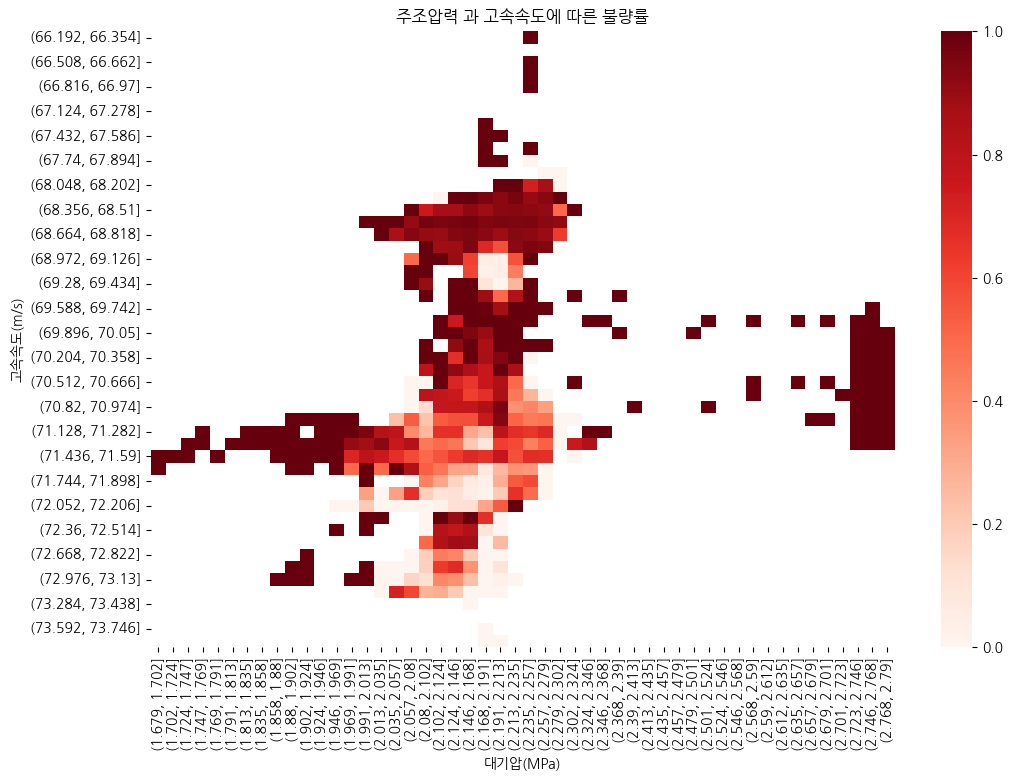

In [16]:
# 주조압력, 고속속도 구간 나누기
df['주조압력_bin'] = pd.cut(df['주조압력(MPa)'], bins=50)
df['고속속도_bin'] = pd.cut(df['고속속도(m/s)'], bins=50)

# 구간별 불량률 계산
heatmap_data = df.groupby(['주조압력_bin','고속속도_bin'])['불량여부'].mean().unstack()

# 시각화
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, cmap='Reds', annot=False)
plt.title('주조압력 과 고속속도에 따른 불량률')
plt.xlabel('대기압(MPa)')
plt.ylabel('고속속도(m/s)')
plt.show()

Text(0, 0.5, '빈도수')

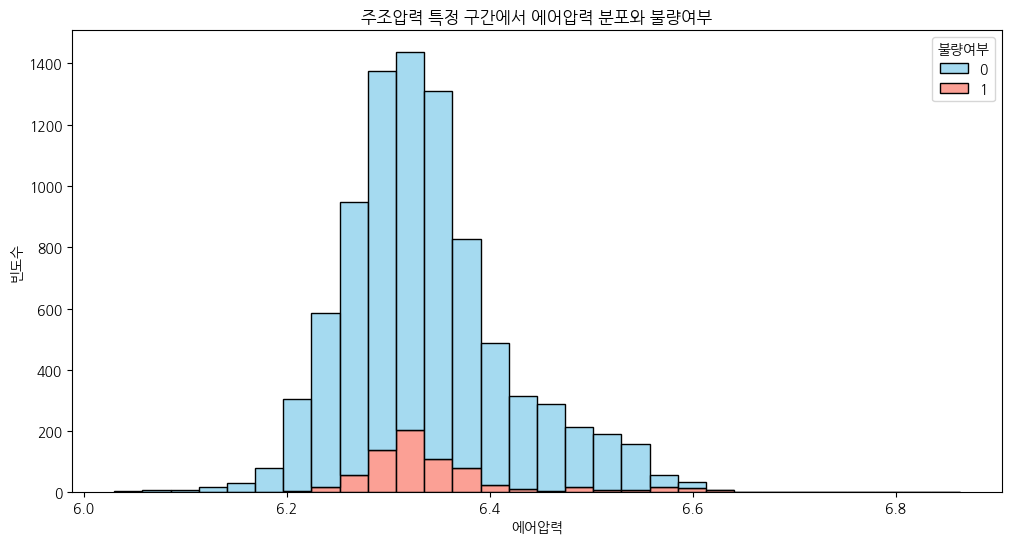

In [17]:
subset = df[((df["주조압력(MPa)"] >= 71.847) & (df["주조압력(MPa)"] <= 72.232))|((df["주조압력(MPa)"] >= 69.023) & (df["주조압력(MPa)"] <= 69.408))]

plt.figure(figsize=(12,6))
sns.histplot(data=subset, x='에어압력', hue='불량여부',
             bins=30, multiple='stack', kde=False, palette=['skyblue','salmon'])

plt.title('주조압력 특정 구간에서 에어압력 분포와 불량여부')
plt.xlabel('에어압력')
plt.ylabel('빈도수')



In [18]:
df['주조압력_mid'] = df['주조압력(MPa)'].apply(lambda x: x.mid if isinstance(x, pd._libs.interval.Interval) else x)

# 숫자형 컬럼만 선택해서 상관계수 계산
numeric_cols = df.select_dtypes(include=['float64','int64']).columns
corr = df[numeric_cols].corr()
print(corr['주조압력_mid'].sort_values(ascending=False))

주조압력(MPa)     1.000000
주조압력_mid      1.000000
에어압력          0.463638
저속속도(m/s)     0.439342
고속절환위치(mm)    0.331362
냉각수압력         0.320171
대기압(hPa)      0.113254
대기압(MPa)      0.113254
형체력(%)        0.047793
대기습도         -0.009320
승압시간(ms)     -0.071419
진공도(mmHg)    -0.087122
고속구간(mm)     -0.098658
보온로(℃)       -0.117709
대기온도         -0.138876
탕구두께(mm)     -0.152064
싸이클타임(sec)   -0.188504
고속속도(m/s)    -0.269636
스프레이(sec)    -0.308469
불량여부         -0.320587
불량여부_mid     -0.320587
냉각수온도        -0.328154
Name: 주조압력_mid, dtype: float64


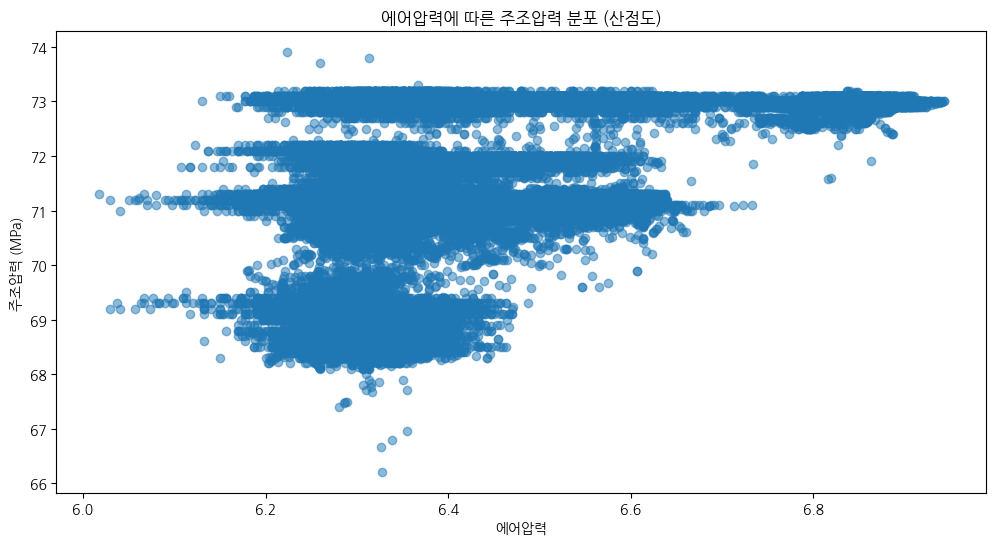

In [19]:
plt.figure(figsize=(12,6))
plt.scatter(df['에어압력'], df['주조압력(MPa)'], alpha=0.5)
plt.xlabel('에어압력')
plt.ylabel('주조압력 (MPa)')
plt.title('에어압력에 따른 주조압력 분포 (산점도)')
plt.show()




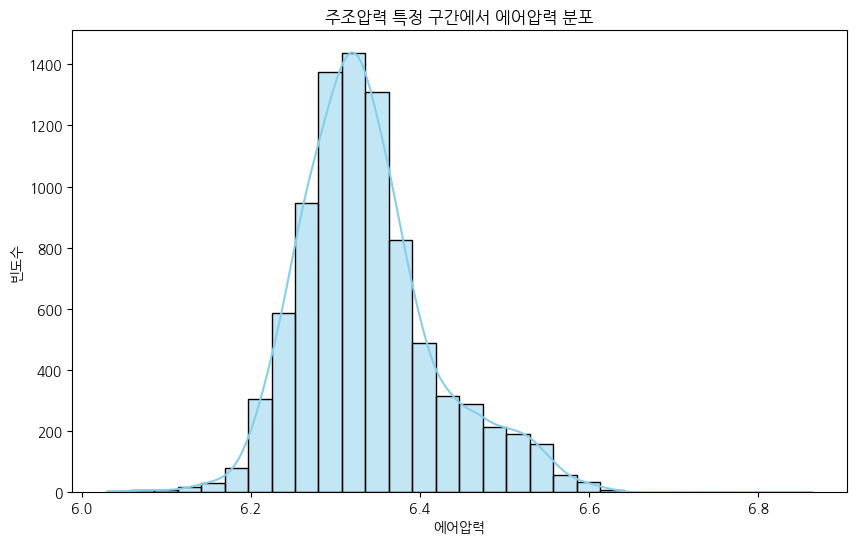

In [20]:
# 1) 주조압력이 특정 구간일 때 (예: 71.847 ~ 72.232 MPa)
target_pressure = df[((df["주조압력(MPa)"] >= 71.847) & (df["주조압력(MPa)"] <= 72.232))|((df["주조압력(MPa)"] >= 69.023) & (df["주조압력(MPa)"] <= 69.408))]

# 2) 이 구간에서 에어압력 분포 확인
plt.figure(figsize=(10,6))
sns.histplot(target_pressure['에어압력'], bins=30, kde=True, color='skyblue')

plt.title('주조압력 특정 구간에서 에어압력 분포')
plt.xlabel('에어압력')
plt.ylabel('빈도수')
plt.show()

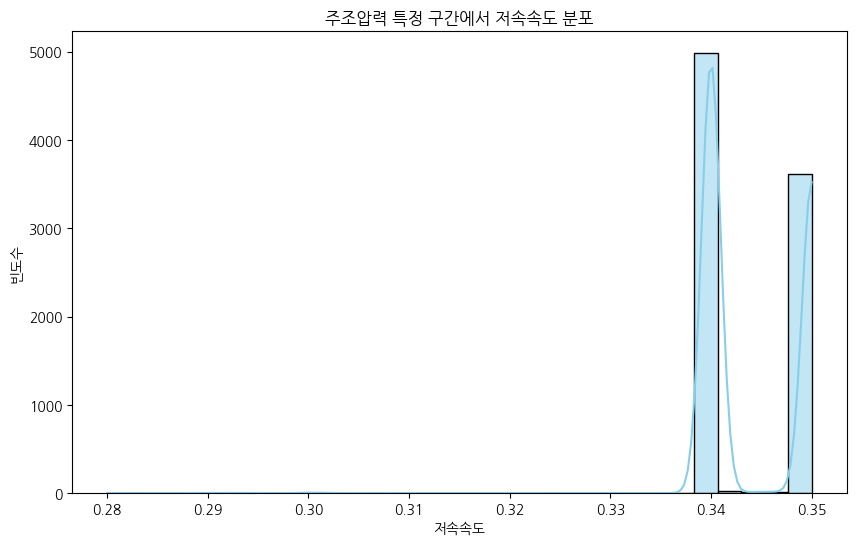

In [21]:
# 1) 주조압력이 특정 구간일 때 (예: 71.847 ~ 72.232 MPa)
target_pressure = df[((df["주조압력(MPa)"] >= 71.847) & (df["주조압력(MPa)"] <= 72.232))|((df["주조압력(MPa)"] >= 69.023) & (df["주조압력(MPa)"] <= 69.408))]

# 2) 이 구간에서 에어압력 분포 확인
plt.figure(figsize=(10,6))
sns.histplot(target_pressure['저속속도(m/s)'], bins=30, kde=True, color='skyblue')

plt.title('주조압력 특정 구간에서 저속속도 분포')
plt.xlabel('저속속도')
plt.ylabel('빈도수')
plt.show()

냉각수 압력

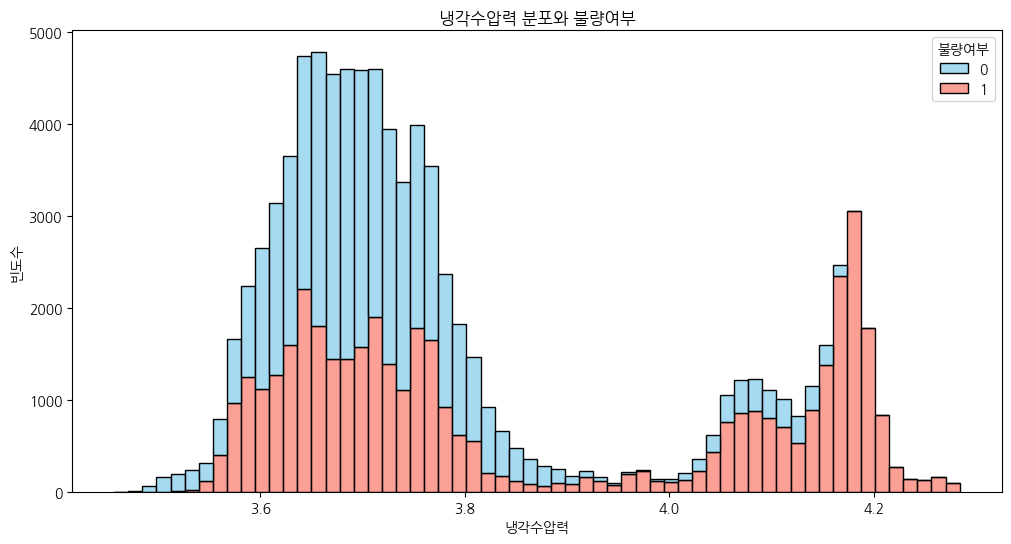

In [22]:
plt.figure(figsize=(12,6))

# 히스토그램: 불량 여부에 따라 색 다르게
sns.histplot(data=df, x='냉각수압력', hue='불량여부', bins=60, kde=False, multiple='stack', palette=['skyblue','salmon'])

plt.title('냉각수압력 분포와 불량여부')
plt.xlabel('냉각수압력')
plt.ylabel('빈도수')
plt.show()

In [23]:
# 1. 압력 구간 나누기 (10개 구간)
df['압력구간'] = pd.cut(df['냉각수압력'], bins=60)

# 2. 구간별 통계 계산
table = df.groupby('압력구간')['불량여부'].agg(
    불량수='sum',         # 불량 1의 개수
    전체수='count',        # 구간 내 전체 데이터 수
    불량률='mean'          # 평균 = 불량률
).reset_index()

print(table)

              압력구간   불량수   전체수       불량률
0   (3.456, 3.471]     1     5  0.200000
1   (3.471, 3.485]     0    17  0.000000
2   (3.485, 3.498]     5    71  0.070423
3   (3.498, 3.512]     5   163  0.030675
4   (3.512, 3.526]    16   195  0.082051
5    (3.526, 3.54]    23   242  0.095041
6    (3.54, 3.553]   121   314  0.385350
7   (3.553, 3.567]   403   796  0.506281
8   (3.567, 3.581]   968  1660  0.583133
9   (3.581, 3.595]  1252  2244  0.557932
10  (3.595, 3.609]  1120  2649  0.422801
11  (3.609, 3.622]  1276  3141  0.406240
12  (3.622, 3.636]  1596  3648  0.437500
13   (3.636, 3.65]  2205  4732  0.465976
14   (3.65, 3.664]  1809  4775  0.378848
15  (3.664, 3.678]  1451  4536  0.319885
16  (3.678, 3.691]  1450  4599  0.315286
17  (3.691, 3.705]  1580  4581  0.344903
18  (3.705, 3.719]  1908  4597  0.415053
19  (3.719, 3.733]  1396  3944  0.353955
20  (3.733, 3.746]  1108  3369  0.328881
21   (3.746, 3.76]  1784  3989  0.447230
22   (3.76, 3.774]  1657  3545  0.467419
23  (3.774, 3.78

/tmp/ipython-input-465839199.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby('압력구간')['불량여부'].agg(


In [24]:
df['냉각수압력_mid'] = df['냉각수압력'].apply(lambda x: x.mid if isinstance(x, pd._libs.interval.Interval) else x)

# 숫자형 컬럼만 선택해서 상관계수 계산
numeric_cols = df.select_dtypes(include=['float64','int64']).columns
corr = df[numeric_cols].corr()
print(corr['냉각수압력_mid'].sort_values(ascending=False))

냉각수압력         1.000000
냉각수압력_mid     1.000000
에어압력          0.877419
불량여부_mid      0.364504
불량여부          0.364504
대기습도          0.321979
주조압력(MPa)     0.320171
주조압력_mid      0.320171
고속절환위치(mm)    0.089145
저속속도(m/s)     0.060921
고속구간(mm)      0.037808
승압시간(ms)      0.032354
진공도(mmHg)    -0.054406
대기압(MPa)     -0.058693
대기압(hPa)     -0.058693
보온로(℃)       -0.062219
싸이클타임(sec)   -0.113280
대기온도         -0.150189
고속속도(m/s)    -0.211198
스프레이(sec)    -0.213047
탕구두께(mm)     -0.262844
냉각수온도        -0.312103
형체력(%)       -0.353470
Name: 냉각수압력_mid, dtype: float64


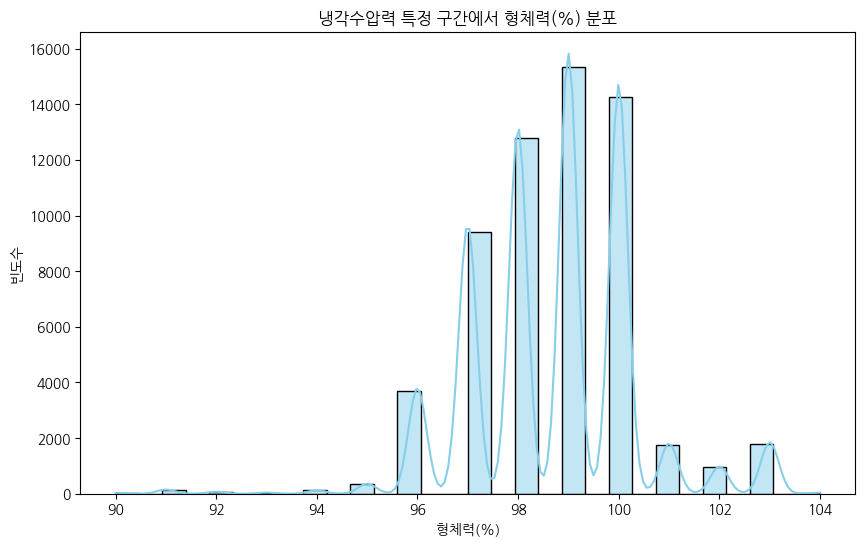

In [25]:
# 1) 냉각수압력이 특정 구간일 때
target_pressure = df[((df["냉각수압력"] >=3.595) & (df["냉각수압력"] <= 3.898))]

# 2) 이 구간에서 에어압력 분포 확인
plt.figure(figsize=(10,6))
sns.histplot(target_pressure['형체력(%)'], bins=30, kde=True, color='skyblue')

plt.title('냉각수압력 특정 구간에서 형체력(%) 분포')
plt.xlabel('형체력(%)')
plt.ylabel('빈도수')
plt.show()

에어압력

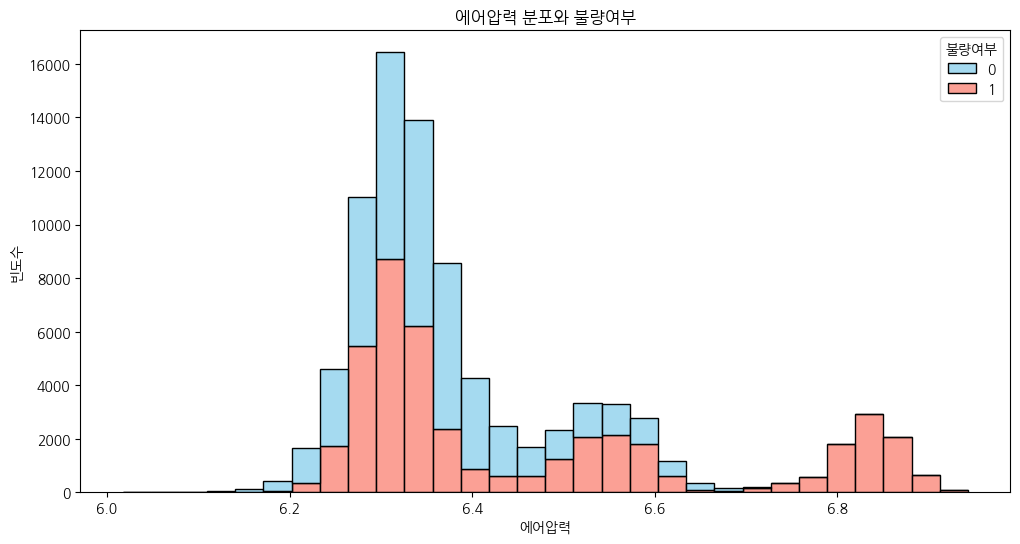

In [26]:
plt.figure(figsize=(12,6))

# 히스토그램: 불량 여부에 따라 색 다르게
sns.histplot(data=df, x='에어압력', hue='불량여부', bins=30, kde=False, multiple='stack', palette=['skyblue','salmon'])

plt.title('에어압력 분포와 불량여부')
plt.xlabel('에어압력')
plt.ylabel('빈도수')
plt.show()

In [27]:
# 1. 압력 구간 나누기 (10개 구간)
df['압력구간'] = pd.cut(df['에어압력'], bins=60)

# 2. 구간별 통계 계산
table = df.groupby('압력구간')['불량여부'].agg(
    불량수='sum',         # 불량 1의 개수
    전체수='count',        # 구간 내 전체 데이터 수
    불량률='mean'          # 평균 = 불량률
).reset_index()

print(table)

              압력구간   불량수   전체수       불량률
0   (6.016, 6.032]     1     3  0.333333
1   (6.032, 6.048]     0     3  0.000000
2   (6.048, 6.063]     1     6  0.166667
3   (6.063, 6.079]     0     7  0.000000
4   (6.079, 6.094]     1     9  0.111111
5    (6.094, 6.11]     0     8  0.000000
6    (6.11, 6.125]     0    18  0.000000
7    (6.125, 6.14]     1    31  0.032258
8    (6.14, 6.156]     5    45  0.111111
9   (6.156, 6.171]    20    96  0.208333
10  (6.171, 6.187]    27   117  0.230769
11  (6.187, 6.202]    32   296  0.108108
12  (6.202, 6.218]    98   574  0.170732
13  (6.218, 6.233]   243  1072  0.226679
14  (6.233, 6.248]   555  1536  0.361328
15  (6.248, 6.264]  1193  3066  0.389106
16  (6.264, 6.279]  2130  4254  0.500705
17  (6.279, 6.295]  3324  6786  0.489832
18   (6.295, 6.31]  4284  8415  0.509091
19   (6.31, 6.326]  4436  8012  0.553669
20  (6.326, 6.341]  3701  8089  0.457535
21  (6.341, 6.357]  2517  5798  0.434115
22  (6.357, 6.372]  1542  4996  0.308647
23  (6.372, 6.38

/tmp/ipython-input-1814216848.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby('압력구간')['불량여부'].agg(


In [28]:
df['에어압력_mid'] = df['에어압력'].apply(lambda x: x.mid if isinstance(x, pd._libs.interval.Interval) else x)

# 숫자형 컬럼만 선택해서 상관계수 계산
numeric_cols = df.select_dtypes(include=['float64','int64']).columns
corr = df[numeric_cols].corr()
print(corr['에어압력_mid'].sort_values(ascending=False))

에어압력_mid      1.000000
에어압력          1.000000
냉각수압력         0.877419
냉각수압력_mid     0.877419
주조압력(MPa)     0.463638
주조압력_mid      0.463638
불량여부          0.309862
불량여부_mid      0.309862
대기습도          0.215776
고속절환위치(mm)    0.209550
대기압(MPa)      0.132887
대기압(hPa)      0.132887
저속속도(m/s)     0.093260
보온로(℃)        0.055376
승압시간(ms)      0.042722
진공도(mmHg)     0.027300
고속구간(mm)     -0.030017
형체력(%)       -0.174880
싸이클타임(sec)   -0.190609
고속속도(m/s)    -0.228074
스프레이(sec)    -0.252581
탕구두께(mm)     -0.295658
대기온도         -0.312107
냉각수온도        -0.448349
Name: 에어압력_mid, dtype: float64


/tmp/ipython-input-1349912556.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df.groupby(['냉각수압력_bin','에어압력_bin'])['불량여부'].mean().unstack()


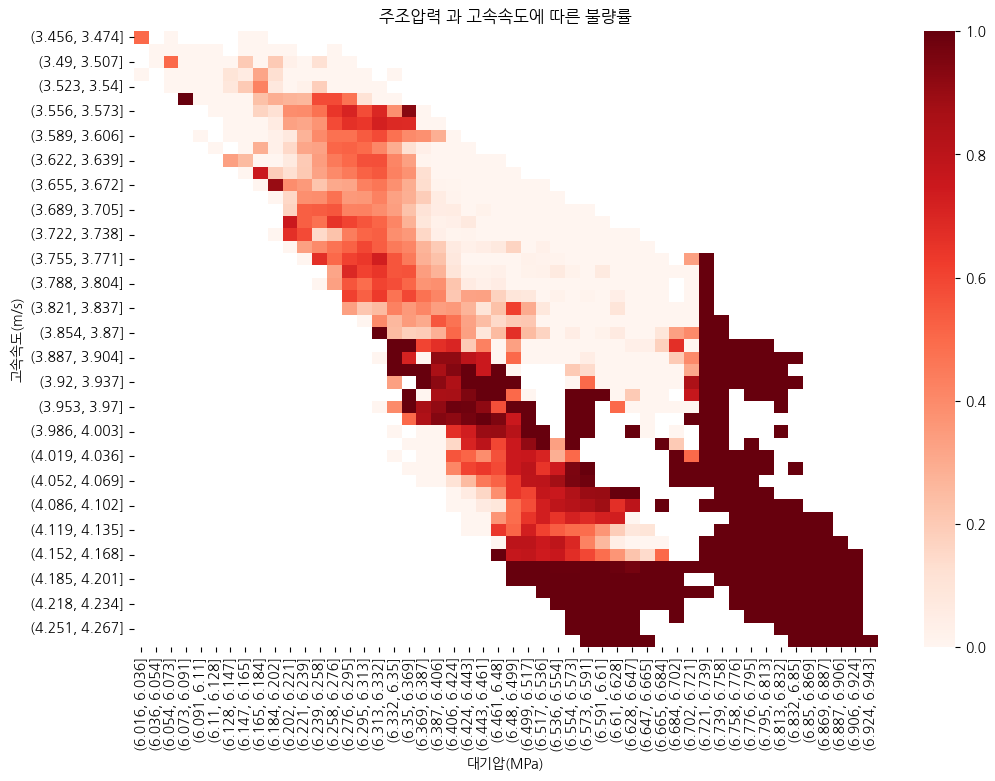

In [29]:
# 냉각수압력, 에어압력 구간 나누기
df['냉각수압력_bin'] = pd.cut(df['냉각수압력'], bins=50)
df['에어압력_bin'] = pd.cut(df['에어압력'], bins=50)

# 구간별 불량률 계산
heatmap_data = df.groupby(['냉각수압력_bin','에어압력_bin'])['불량여부'].mean().unstack()

# 시각화
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, cmap='Reds', annot=False)
plt.title('주조압력 과 고속속도에 따른 불량률')
plt.xlabel('대기압(MPa)')
plt.ylabel('고속속도(m/s)')
plt.show()

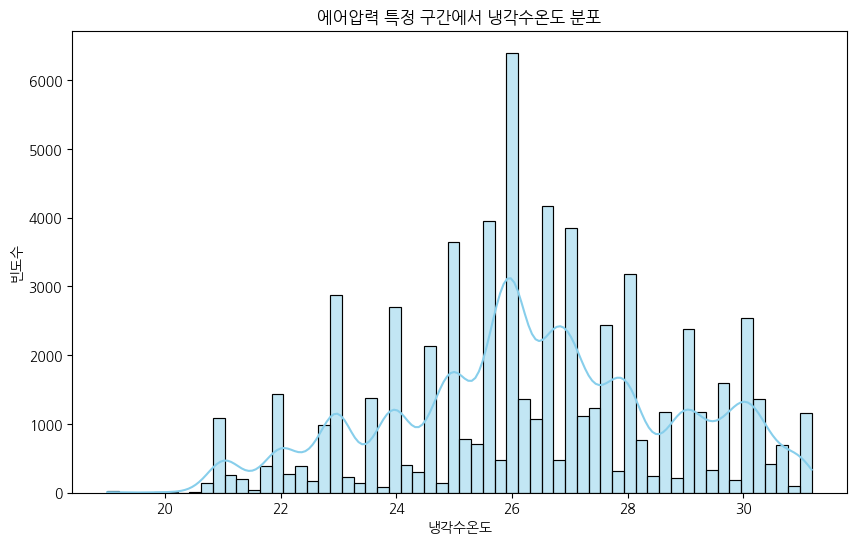

In [30]:
# 1) 냉각수압력이 특정 구간일 때
target_pressure = df[((df["에어압력"] >=6.016) & (df["에어압력"] <= 6.48))]

# 2) 이 구간에서 에어압력 분포 확인
plt.figure(figsize=(10,6))
sns.histplot(target_pressure['냉각수온도'], bins=60, kde=True, color='skyblue')

plt.title('에어압력 특정 구간에서 냉각수온도 분포')
plt.xlabel('냉각수온도')
plt.ylabel('빈도수')
plt.show()

**승압시간**

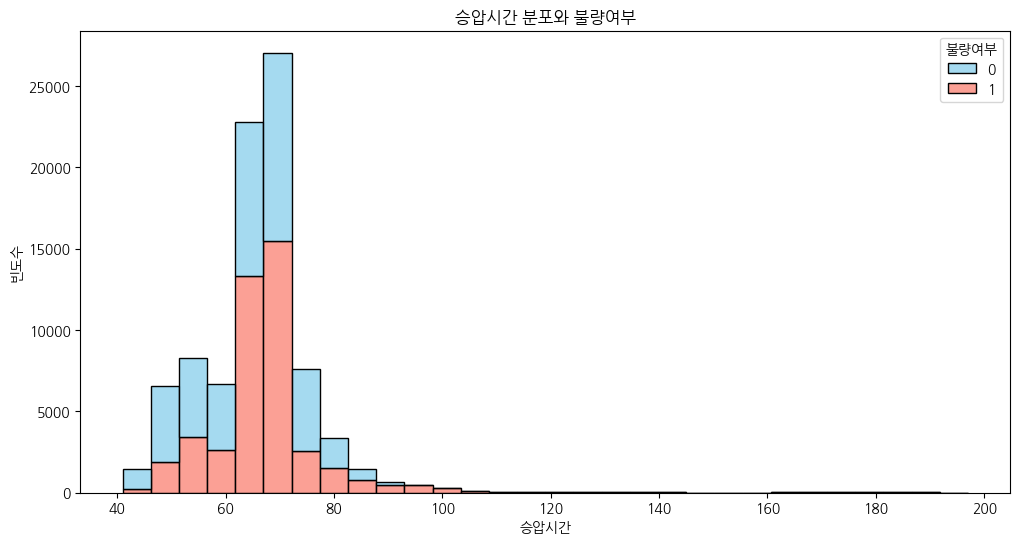

In [31]:
plt.figure(figsize=(12,6))

# 히스토그램: 불량 여부에 따라 색 다르게
sns.histplot(data=df, x='승압시간(ms)', hue='불량여부', bins=30, kde=False, multiple='stack', palette=['skyblue','salmon'])

plt.title ('승압시간 분포와 불량여부')
plt.xlabel('승압시간')
plt.ylabel('빈도수')
plt.show()

**형체력**

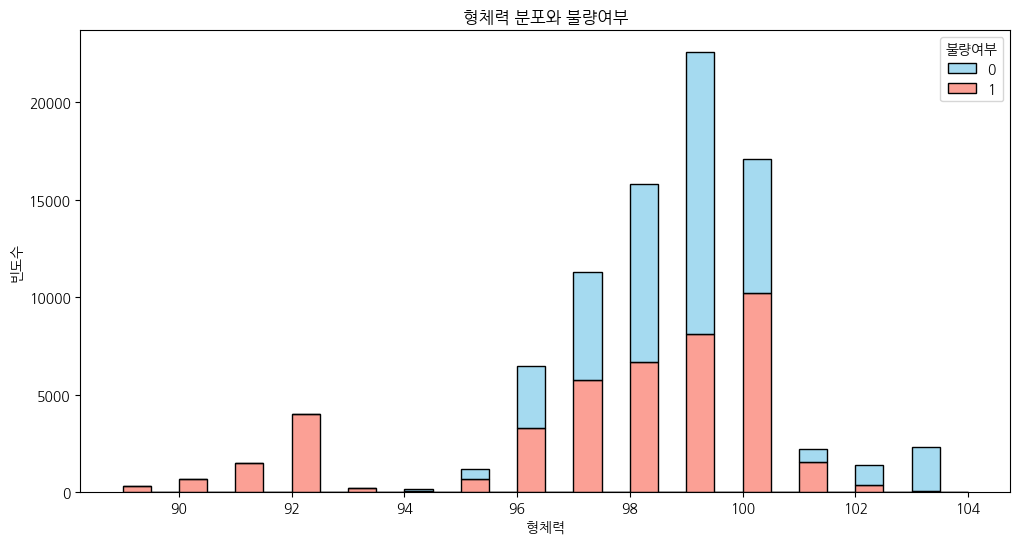

In [32]:
plt.figure(figsize=(12,6))

# 히스토그램: 불량 여부에 따라 색 다르게
sns.histplot(data=df, x='형체력(%)', hue='불량여부', bins=30, kde=False, multiple='stack', palette=['skyblue','salmon'])

plt.title ('형체력 분포와 불량여부')
plt.xlabel('형체력')
plt.ylabel('빈도수')
plt.show()

In [33]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 예시: 독립변수만 뽑기 (y제외)
X = df[['저속속도(m/s)', '고속속도(m/s)',
        '고속구간(mm)', '주조압력(MPa)', '탕구두께(mm)',
        '승압시간(ms)', '스프레이(sec)',
        '형체력(%)', '진공도(mmHg)', '보온로(℃)', '에어압력',
        '냉각수온도', '냉각수압력', '대기온도', '대기습도']]

# 상수항 추가 (statsmodels에서 필요)
X_const = sm.add_constant(X)

# VIF 계산
vif = pd.DataFrame()
vif["feature"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i)
              for i in range(X_const.shape[1])]

print(vif)

      feature            VIF
0       const  125774.142377
1   저속속도(m/s)       6.930022
2   고속속도(m/s)      10.193090
3    고속구간(mm)       1.826491
4   주조압력(MPa)       5.081275
5    탕구두께(mm)       1.558901
6    승압시간(ms)       1.337832
7   스프레이(sec)      14.380357
8      형체력(%)       1.466201
9   진공도(mmHg)       1.402827
10     보온로(℃)       2.022813
11       에어압력       6.916943
12      냉각수온도       5.580761
13      냉각수압력       6.459723
14       대기온도       4.989836
15       대기습도       2.077060


In [34]:
X = df.drop(columns=['불량여부'])
y = df['불량여부']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
ridge_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
ridge_model.fit(X_train_scaled, y_train)
y_pred = ridge_model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

TypeError: float() argument must be a string or a real number, not 'pandas._libs.interval.Interval'

In [ ]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge_model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)

In [ ]:
coef = ridge_model.coef_[0]
features = X.columns

plt.figure(figsize=(10,6))
plt.barh(features, coef)
plt.xlabel("Coefficient")
plt.title("Ridge Coefficients")
plt.show()

In [ ]:
y_pred = ridge_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))